In [2]:
import numpy as np
import pandas as pd

def get_major_cn(df):
    n = len(np.unique(df.mutation))
    m = sum(df.mutation == np.unique(df.mutation)[0])
    res = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            index = i * m + j
            res[i, j] = df.iloc[index , :].major_cn
    return res

def get_b_mat(df):
    n = len(np.unique(df.mutation))
    m = sum(df.mutation == np.unique(df.mutation)[0])
    res = np.zeros([n, m])
    tumor_cn_mat = get_tumor_cn_mat(df)
    normal_cn_mat = get_normal_cn_mat(df)
    purity_mat = get_purity_mat(df)
    major_cn_mat = get_major_cn(df)
    read_mat = get_read_mat(df)
    total_read_mat = get_total_read_mat(df)
    
    # for i in range(n):
    #     for j in range(m):
    #         index = i * m + j
    #         res[i, j] = df.iloc[index , :].multiplicity
    
    for i in range(n):
        for j in range(m):
            temp = read_mat[i, j] * (purity_mat[i, j] * tumor_cn_mat[i, j] + normal_cn_mat[i, j] * (1 - purity_mat[i, j]))\
                / (total_read_mat[i, j] * purity_mat[i, j])
            temp = 1 if np.round(temp) == 0 else np.round(temp)
            res[i, j] = np.min([temp, major_cn_mat[i, j]])
    return res

def get_tumor_cn_mat(df):
    n = len(np.unique(df.mutation))
    m = sum(df.mutation == np.unique(df.mutation)[0])
    res = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            index = i * m + j
            res[i, j] = df.iloc[index , ].major_cn + df.iloc[index , ].minor_cn
    return res

def get_normal_cn_mat(df):
    n = len(np.unique(df.mutation))
    m = sum(df.mutation == np.unique(df.mutation)[0])
    res = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            index = i * m + j
            res[i, j] = df.iloc[index , ].normal_cn
    return res

def get_purity_mat(df):
    n = len(np.unique(df.mutation))
    m = sum(df.mutation == np.unique(df.mutation)[0])
    res = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            index = i * m + j
            res[i, j] = df.iloc[index , ].tumour_purity
    return res

def get_read_mat(df):
    n = len(np.unique(df.mutation))
    m = sum(df.mutation == np.unique(df.mutation)[0])
    res = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            index = i * m + j
            res[i, j] = df.iloc[index , ].alt_counts
    return res

def get_total_read_mat(df):
    n = len(np.unique(df.mutation))
    m = sum(df.mutation == np.unique(df.mutation)[0])
    res = np.zeros([n, m])
    for i in range(n):
        for j in range(m):
            index = i * m + j
            res[i, j] = df.iloc[index , ].alt_counts + df.iloc[index , ].ref_counts
    return res

def get_c_mat(df):

    tumor_cn_mat = get_tumor_cn_mat(df)
    normal_cn_mat = get_normal_cn_mat(df)
    purity_mat = get_purity_mat(df)
    b_mat = get_b_mat(df)
    c_mat = b_mat / ((1 - purity_mat) * normal_cn_mat + purity_mat * tumor_cn_mat)
    return c_mat

Loaded SNV data from AVPC/ACC9/9-pre.snv.txt with shape (5576, 4)
Loaded CNA data from AVPC/ACC9/9-pre.cna.txt with shape (277, 6)
Purity: 0.31
Constructed df with shape (5576, 10)


C:\Users\mhdy1\AppData\Local\Temp\ipykernel_14436\1813244879.py:112: RuntimeWarning: divide by zero encountered in divide
  ccf_corrected = ccf_vec / c_mat


Dropped 1 rows with invalid (NaN or infinite) CCF values.
Final CCF range: min 0.031190476190476192, max 1.3548387096774193
Loaded SNV data from AVPC/ACC9/9-post.snv.txt with shape (3862, 4)
Loaded CNA data from AVPC/ACC9/9-post.cna.txt with shape (181, 6)
Purity: 0.21
Constructed df with shape (3862, 10)


C:\Users\mhdy1\AppData\Local\Temp\ipykernel_14436\1813244879.py:112: RuntimeWarning: divide by zero encountered in divide
  ccf_corrected = ccf_vec / c_mat


Dropped 2 rows with invalid (NaN or infinite) CCF values.
Final CCF range: min 0.037037037037037035, max 0.8714285714285714


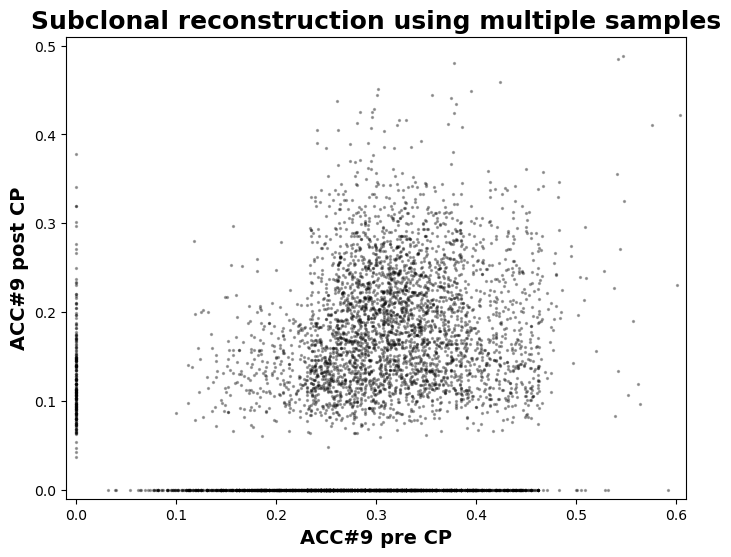

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_files(snvfile, cnafile, purityfile):
    """
    Process SNV, CNA, and purity files into a DataFrame with computed CCF.
    
    Parameters:
      - snvfile: path to the SNV file.
      - cnafile: path to the CNA file.
      - purityfile: path to the purity file.
    
    Returns:
      A pandas DataFrame containing the following columns:
        'mutation_chrom', 'mutation', 'position', 'region', 'ref_counts',
        'alt_counts', 'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity', 'ccf'
    """
    # ---------------------------
    # Load data from files.
    dfsnv = pd.read_csv(snvfile, sep='\t')
    dfcna = pd.read_csv(cnafile, sep='\t')
    with open(purityfile, 'r') as file:
        purity = float(file.read().strip())

    # ---------------------------
    # Check that required columns exist in the input files.
    required_snv_cols = {'chromosome_index', 'position', 'ref_count', 'alt_count'}
    required_cna_cols = {'chr', 'startpos', 'endpos', 'nMajor', 'nMinor'}
    missing_snv = required_snv_cols - set(dfsnv.columns)
    missing_cna = required_cna_cols - set(dfcna.columns)
    assert not missing_snv, f"Missing required columns in SNV file: {missing_snv}"
    assert not missing_cna, f"Missing required columns in CNA file: {missing_cna}"

    # Ensure purity is within a plausible range.
    assert 0 <= purity <= 1, f"Tumour purity must be between 0 and 1, but got {purity}"
    
    print(f"Loaded SNV data from {snvfile} with shape {dfsnv.shape}")
    print(f"Loaded CNA data from {cnafile} with shape {dfcna.shape}")
    print(f"Purity: {purity}")

    # ---------------------------
    # Initialize copy number lists.
    major_cn = []
    minor_cn = []
    
    # Iterate over SNV rows and match each row in the CNA DataFrame by chromosome and position range.
    for idx, row in dfsnv.iterrows():
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['chromosome_index'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            major_cn.append(matching_rows['nMajor'].iloc[0])
            minor_cn.append(matching_rows['nMinor'].iloc[0])
        else:
            major_cn.append(1)
            minor_cn.append(1)
    
    # Validate that the copy number lists have the same length as SNV rows.
    assert len(major_cn) == dfsnv.shape[0], "Length of major_cn does not match the number of SNV rows"
    assert len(minor_cn) == dfsnv.shape[0], "Length of minor_cn does not match the number of SNV rows"
    
    # ---------------------------
    # Construct the DataFrame.
    df = pd.DataFrame({
        'mutation_chrom': dfsnv['chromosome_index'],
        'mutation': dfsnv['position'],  # Preserve the mutation location if needed.
        'position': dfsnv['position'],
        'region': 1,  # Assuming region is 1 for all rows.
        'ref_counts': dfsnv['ref_count'],
        'alt_counts': dfsnv['alt_count'],
        'major_cn': major_cn,
        'minor_cn': minor_cn,
        'normal_cn': [2] * len(major_cn),
        'tumour_purity': [purity] * len(major_cn)
    })
    
    # Check that the constructed DataFrame contains all required columns.
    required_df_cols = {'mutation_chrom', 'position', 'ref_counts', 'alt_counts',
                        'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity'}
    missing_df_cols = required_df_cols - set(df.columns)
    assert not missing_df_cols, f"Missing required columns in constructed DataFrame: {missing_df_cols}"
    print(f"Constructed df with shape {df.shape}")
    
    # Additional check: Randomly validate matching in the CNA file.
    sample_idx = np.random.choice(df.index, size=min(5, df.shape[0]), replace=False)
    for idx in sample_idx:
        row = df.loc[idx]
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['mutation_chrom'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            expected_major = matching_rows['nMajor'].iloc[0]
            expected_minor = matching_rows['nMinor'].iloc[0]
            if row['major_cn'] != expected_major or row['minor_cn'] != expected_minor:
                print(f"Warning: Mismatch in row {idx}. Expected major: {expected_major}, minor: {expected_minor}; got major: {row['major_cn']}, minor: {row['minor_cn']}")
        else:
            if row['major_cn'] != 1 or row['minor_cn'] != 1:
                print(f"Warning: No match in CNA for row {idx} but found major_cn={row['major_cn']} and minor_cn={row['minor_cn']}. Expected defaults 1 and 1.")
    
    # ---------------------------
    # Calculate the CCF using the clipp2 function.
    c_mat = get_c_mat(df)
    assert c_mat.shape[0] == df.shape[0], "C-matrix row count must match number of SNV rows"
    
    ccf = df['alt_counts'] / (df['alt_counts'] + df['ref_counts'])
    ccf_vec = ccf.values.reshape(-1, 1)
    ccf_corrected = ccf_vec / c_mat
    df['ccf'] = ccf_corrected

    # ---------------------------
    # Drop rows with NaN or infinite CCF values.
    initial_rows = df.shape[0]
    df = df[np.isfinite(df['ccf'])]
    dropped_rows = initial_rows - df.shape[0]
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows} rows with invalid (NaN or infinite) CCF values.")
    
    print(f"Final CCF range: min {df['ccf'].min()}, max {df['ccf'].max()}")
    return df

def plot_subclonal_reconstruction(post_snv, post_cna, post_purity,
                                   pre_snv, pre_cna, pre_purity):
    """
    Create a scatter plot of CCF values from two datasets (post and pre) with a hexbin
    density overlay. The function takes six file paths:
    
      - post_snv: SNV file for the post sample.
      - post_cna: CNA file for the post sample.
      - post_purity: Purity file for the post sample.
      - pre_snv: SNV file for the pre sample.
      - pre_cna: CNA file for the pre sample.
      - pre_purity: Purity file for the pre sample.
    
    The function processes the data, calculates CCF, matches rows based on mutation_chrom and position,
    and then plots the scatter plot with density, using small black dots. The x‑axis and y‑axis
    limits are set using the tumour purity from each dataset plus 0.3. The title and axis labels are
    made bold and larger. No grid or legends appear.
    """
    # Process files for both datasets.
    df1 = process_files(post_snv, post_cna, post_purity)
    df2 = process_files(pre_snv, pre_cna, pre_purity)
    
    # -----------------------------------------------------------------------------
    # Build sets of unique keys (mutation_chrom, position) for each DataFrame.
    keys_df1 = set(zip(df1['mutation_chrom'], df1['position']))
    keys_df2 = set(zip(df2['mutation_chrom'], df2['position']))
    
    # Identify matched and unmatched keys.
    matched_keys       = keys_df1.intersection(keys_df2)
    unmatched_df1_keys = keys_df1 - keys_df2
    unmatched_df2_keys = keys_df2 - keys_df1
    
    # Create lookup dictionaries for fast access to the 'ccf' values.
    df1_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df1.iterrows()}
    df2_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df2.iterrows()}
    
    # Process matched rows.
    x_matched = [df1_dict[key] for key in matched_keys]
    y_matched = [df2_dict[key] for key in matched_keys]
    
    # Process unmatched rows.
    # For rows that appear only in df1, set (df1['ccf'], 0)
    x_unmatched = [df1_dict[key] for key in unmatched_df1_keys]
    y_unmatched = [0 for _ in unmatched_df1_keys]
    # For rows that appear only in df2, set (0, df2['ccf'])
    x_unmatched += [0 for _ in unmatched_df2_keys]
    y_unmatched += [df2_dict[key] for key in unmatched_df2_keys]
    
    # -----------------------------------------------------------------------------
    # Plotting:
    plt.figure(figsize=(8, 6))
    
    # Combine all x and y values.
    all_x = np.concatenate([np.array(x_matched).flatten(), np.array(x_unmatched).flatten()])
    all_y = np.concatenate([np.array(y_matched).flatten(), np.array(y_unmatched).flatten()])
    
    # # Create a hexbin density plot with a finer grid; use a red colormap.
    # hb = plt.hexbin(all_x, all_y, gridsize=100, cmap='Reds', alpha=0.7, mincnt=1)
    # plt.colorbar(hb, label='Density')
    
    # Plot the scatter points with very small black dots with very low opacity (lighter).
    plt.scatter(x_matched, y_matched, color='k', s=2, alpha=0.3)
    plt.scatter(x_unmatched, y_unmatched, color='k', s=2, alpha=0.3)
    
    # Set x and y axis limits:
    # Lower bounds are set using tumour purity from each dataset plus 0.3.
    x_lower = -0.01
    y_lower = -0.01
    x_upper = df1['tumour_purity'].iloc[0] + 0.3
    y_upper = df2['tumour_purity'].iloc[0] + 0.3
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    
    # Make the axis labels and title bold and larger.
    plt.xlabel('ACC#9 pre CP', fontsize=14, fontweight='bold')
    plt.ylabel('ACC#9 post CP', fontsize=14, fontweight='bold')
    plt.title('Subclonal reconstruction using multiple samples', fontsize=18, fontweight='bold')
    
    # Remove grid.
    plt.grid(False)
    
    plt.show()


# Example call:
plot_subclonal_reconstruction('AVPC/ACC9/9-pre.snv.txt', 'AVPC/ACC9/9-pre.cna.txt', 'AVPC/ACC9/9-pre.purity.txt',
                              'AVPC/ACC9/9-post.snv.txt', 'AVPC/ACC9/9-post.cna.txt', 'AVPC/ACC9/9-post.purity.txt'
                              )

Loaded SNV data from AVPC/ACC55/55-pre.snv.txt with shape (8956, 4)
Loaded CNA data from AVPC/ACC55/55-pre.cna.txt with shape (312, 5)
Purity: 0.67
Constructed df with shape (8956, 10)
Final CCF range: min 0.019746121297602257, max 1.85
Loaded SNV data from AVPC/ACC55/55-post.snv.txt with shape (9952, 4)
Loaded CNA data from AVPC/ACC55/55-post.cna.txt with shape (355, 5)
Purity: 0.87
Constructed df with shape (9952, 10)
Final CCF range: min 0.034482758620689655, max 1.8846153846153846
1376
2372


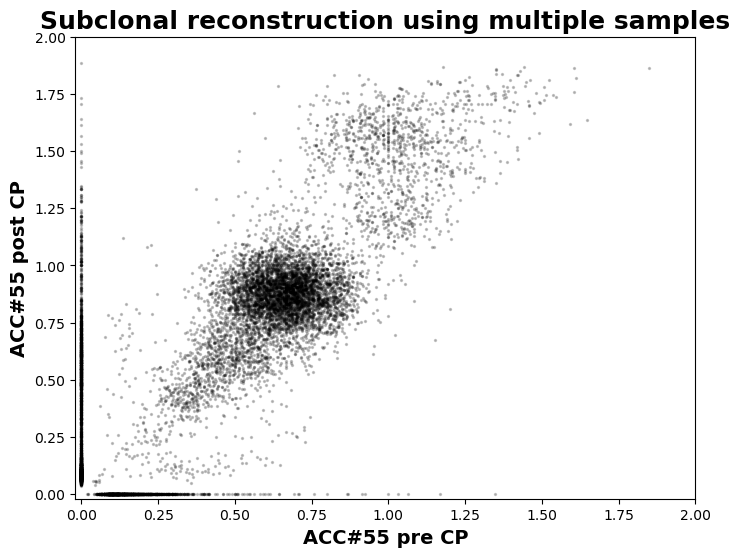

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_files(snvfile, cnafile, purityfile):
    """
    Process SNV, CNA, and purity files into a DataFrame with computed CCF.
    
    Parameters:
      - snvfile: path to the SNV file.
      - cnafile: path to the CNA file.
      - purityfile: path to the purity file.
    
    Returns:
      A pandas DataFrame containing the following columns:
        'mutation_chrom', 'mutation', 'position', 'region', 'ref_counts',
        'alt_counts', 'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity', 'ccf'
    """
    # ---------------------------
    # Load data from files.
    dfsnv = pd.read_csv(snvfile, sep='\t')
    dfcna = pd.read_csv(cnafile, sep='\t')
    with open(purityfile, 'r') as file:
        purity = float(file.read().strip())

    # ---------------------------
    # Check that required columns exist in the input files.
    required_snv_cols = {'chromosome_index', 'position', 'ref_count', 'alt_count'}
    required_cna_cols = {'chr', 'startpos', 'endpos', 'nMajor', 'nMinor'}
    missing_snv = required_snv_cols - set(dfsnv.columns)
    missing_cna = required_cna_cols - set(dfcna.columns)
    assert not missing_snv, f"Missing required columns in SNV file: {missing_snv}"
    assert not missing_cna, f"Missing required columns in CNA file: {missing_cna}"

    # Ensure purity is within a plausible range.
    assert 0 <= purity <= 1, f"Tumour purity must be between 0 and 1, but got {purity}"
    
    print(f"Loaded SNV data from {snvfile} with shape {dfsnv.shape}")
    print(f"Loaded CNA data from {cnafile} with shape {dfcna.shape}")
    print(f"Purity: {purity}")

    # ---------------------------
    # Initialize copy number lists.
    major_cn = []
    minor_cn = []
    
    # Iterate over SNV rows and match each row in the CNA DataFrame by chromosome and position range.
    for idx, row in dfsnv.iterrows():
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['chromosome_index'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            major_cn.append(matching_rows['nMajor'].iloc[0])
            minor_cn.append(matching_rows['nMinor'].iloc[0])
        else:
            major_cn.append(1)
            minor_cn.append(1)
    
    # Validate that the copy number lists have the same length as SNV rows.
    assert len(major_cn) == dfsnv.shape[0], "Length of major_cn does not match the number of SNV rows"
    assert len(minor_cn) == dfsnv.shape[0], "Length of minor_cn does not match the number of SNV rows"
    
    # ---------------------------
    # Construct the DataFrame.
    df = pd.DataFrame({
        'mutation_chrom': dfsnv['chromosome_index'],
        'mutation': dfsnv['position'],  # Preserve the mutation location if needed.
        'position': dfsnv['position'],
        'region': 1,  # Assuming region is 1 for all rows.
        'ref_counts': dfsnv['ref_count'],
        'alt_counts': dfsnv['alt_count'],
        'major_cn': major_cn,
        'minor_cn': minor_cn,
        'normal_cn': [2] * len(major_cn),
        'tumour_purity': [purity] * len(major_cn)
    })
    
    # Check that the constructed DataFrame contains all required columns.
    required_df_cols = {'mutation_chrom', 'position', 'ref_counts', 'alt_counts',
                        'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity'}
    missing_df_cols = required_df_cols - set(df.columns)
    assert not missing_df_cols, f"Missing required columns in constructed DataFrame: {missing_df_cols}"
    print(f"Constructed df with shape {df.shape}")
    
    # Additional check: Randomly validate matching in the CNA file.
    sample_idx = np.random.choice(df.index, size=min(5, df.shape[0]), replace=False)
    for idx in sample_idx:
        row = df.loc[idx]
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['mutation_chrom'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            expected_major = matching_rows['nMajor'].iloc[0]
            expected_minor = matching_rows['nMinor'].iloc[0]
            if row['major_cn'] != expected_major or row['minor_cn'] != expected_minor:
                print(f"Warning: Mismatch in row {idx}. Expected major: {expected_major}, minor: {expected_minor}; got major: {row['major_cn']}, minor: {row['minor_cn']}")
        else:
            if row['major_cn'] != 1 or row['minor_cn'] != 1:
                print(f"Warning: No match in CNA for row {idx} but found major_cn={row['major_cn']} and minor_cn={row['minor_cn']}. Expected defaults 1 and 1.")
    
    # ---------------------------
    # Calculate the CCF using the clipp2 function.
    c_mat = get_c_mat(df)
    assert c_mat.shape[0] == df.shape[0], "C-matrix row count must match number of SNV rows"
    
    ccf = df['alt_counts'] / (df['alt_counts'] + df['ref_counts'])
    ccf_vec = ccf.values.reshape(-1, 1)
    ccf_corrected = ccf_vec / c_mat
    df['ccf'] = ccf_corrected

    # ---------------------------
    # Drop rows with NaN or infinite CCF values.
    initial_rows = df.shape[0]
    df = df[np.isfinite(df['ccf'])]
    dropped_rows = initial_rows - df.shape[0]
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows} rows with invalid (NaN or infinite) CCF values.")
    
    print(f"Final CCF range: min {df['ccf'].min()}, max {df['ccf'].max()}")
    return df

def plot_subclonal_reconstruction(post_snv, post_cna, post_purity,
                                   pre_snv, pre_cna, pre_purity):
    """
    Create a scatter plot of CCF values from two datasets (post and pre) with a hexbin
    density overlay. The function takes six file paths:
    
      - post_snv: SNV file for the post sample.
      - post_cna: CNA file for the post sample.
      - post_purity: Purity file for the post sample.
      - pre_snv: SNV file for the pre sample.
      - pre_cna: CNA file for the pre sample.
      - pre_purity: Purity file for the pre sample.
    
    The function processes the data, calculates CCF, matches rows based on mutation_chrom and position,
    and then plots the scatter plot with density, using small black dots. The x‑axis and y‑axis
    limits are set using the tumour purity from each dataset plus 0.3. The title and axis labels are
    made bold and larger. No grid or legends appear.
    """
    # Process files for both datasets.
    df1 = process_files(post_snv, post_cna, post_purity)
    df2 = process_files(pre_snv, pre_cna, pre_purity)
    
    # -----------------------------------------------------------------------------
    # Build sets of unique keys (mutation_chrom, position) for each DataFrame.
    keys_df1 = set(zip(df1['mutation_chrom'], df1['position']))
    keys_df2 = set(zip(df2['mutation_chrom'], df2['position']))
    
    # Identify matched and unmatched keys.
    matched_keys       = keys_df1.intersection(keys_df2)
    unmatched_df1_keys = keys_df1 - keys_df2
    unmatched_df2_keys = keys_df2 - keys_df1
    
    # Create lookup dictionaries for fast access to the 'ccf' values.
    df1_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df1.iterrows()}
    df2_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df2.iterrows()}
    
    # Process matched rows.
    x_matched = [df1_dict[key] for key in matched_keys]
    y_matched = [df2_dict[key] for key in matched_keys]
    
    # Process unmatched rows.
    # For rows that appear only in df1, set (df1['ccf'], 0)
    x_unmatched = [df1_dict[key] for key in unmatched_df1_keys]
    print(len(unmatched_df1_keys))
    y_unmatched = [0 for _ in unmatched_df1_keys]
    # For rows that appear only in df2, set (0, df2['ccf'])
    x_unmatched += [0 for _ in unmatched_df2_keys]
    y_unmatched += [df2_dict[key] for key in unmatched_df2_keys]
    print(len(unmatched_df2_keys))

    print(len(x_unmatched) + len(x_matched))
    # -----------------------------------------------------------------------------
    # Plotting:
    plt.figure(figsize=(8, 6))
    
    # Combine all x and y values.
    all_x = np.concatenate([np.array(x_matched).flatten(), np.array(x_unmatched).flatten()])
    all_y = np.concatenate([np.array(y_matched).flatten(), np.array(y_unmatched).flatten()])
    
    # # Create a hexbin density plot with a finer grid; use a red colormap.
    # hb = plt.hexbin(all_x, all_y, gridsize=100, cmap='Reds', alpha=0.7, mincnt=1)
    # plt.colorbar(hb, label='Density')
    
    # Plot the scatter points with very small black dots with very low opacity (lighter).
    plt.scatter(x_matched, y_matched, color='k', s=2, alpha=0.2)
    plt.scatter(x_unmatched, y_unmatched, color='k', s=2, alpha=0.2)
    
    # Set x and y axis limits:
    # Lower bounds are set using tumour purity from each dataset plus 0.3.
    x_lower = -0.02
    y_lower = -0.02
    x_upper = 2
    y_upper = 2
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    
    # Make the axis labels and title bold and larger.
    plt.xlabel('ACC#55 pre CP', fontsize=14, fontweight='bold')
    plt.ylabel('ACC#55 post CP', fontsize=14, fontweight='bold')
    plt.title('Subclonal reconstruction using multiple samples', fontsize=18, fontweight='bold')
    
    # Remove grid.
    plt.grid(False)
    
    plt.show()

# Example call with file paths.
plot_subclonal_reconstruction('AVPC/ACC55/55-pre.snv.txt', 'AVPC/ACC55/55-pre.cna.txt', 'AVPC/ACC55/55-pre.purity.txt',
                              'AVPC/ACC55/55-post.snv.txt', 'AVPC/ACC55/55-post.cna.txt', 'AVPC/ACC55/55-post.purity.txt')

Loaded SNV data from AVPC/ACC28/28-pre.snv.txt with shape (4311, 4)
Loaded CNA data from AVPC/ACC28/28-pre.cna.txt with shape (170, 6)
Purity: 0.27
Constructed df with shape (4311, 10)
Final CCF range: min 0.0392156862745098, max 1.278688524590164
Loaded SNV data from AVPC/ACC28/28-post.snv.txt with shape (4645, 4)
Loaded CNA data from AVPC/ACC28/28-post.cna.txt with shape (160, 6)
Purity: 0.51
Constructed df with shape (4645, 10)
Final CCF range: min 0.02774000543921675, max 1.5630252100840336


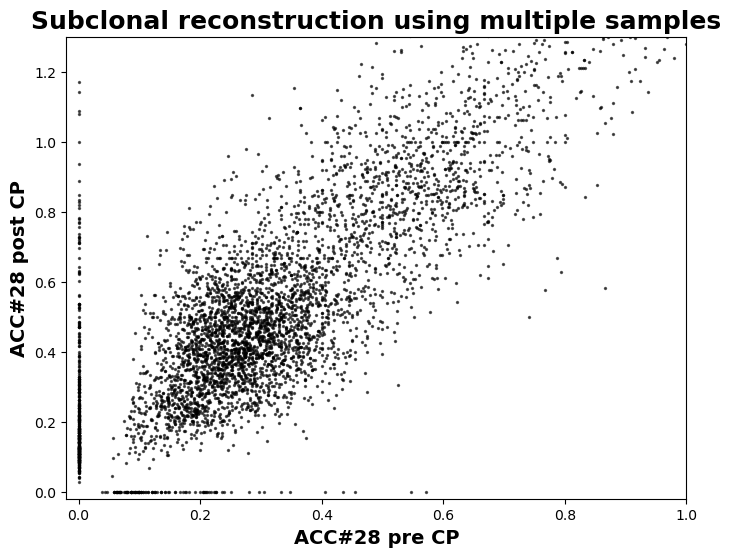

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_files(snvfile, cnafile, purityfile):
    """
    Process SNV, CNA, and purity files into a DataFrame with computed CCF.
    
    Parameters:
      - snvfile: path to the SNV file.
      - cnafile: path to the CNA file.
      - purityfile: path to the purity file.
    
    Returns:
      A pandas DataFrame containing the following columns:
        'mutation_chrom', 'mutation', 'position', 'region', 'ref_counts',
        'alt_counts', 'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity', 'ccf'
    """
    # ---------------------------
    # Load data from files.
    dfsnv = pd.read_csv(snvfile, sep='\t')
    dfcna = pd.read_csv(cnafile, sep='\t')
    with open(purityfile, 'r') as file:
        purity = float(file.read().strip())

    # ---------------------------
    # Check that required columns exist in the input files.
    required_snv_cols = {'chromosome_index', 'position', 'ref_count', 'alt_count'}
    required_cna_cols = {'chr', 'startpos', 'endpos', 'nMajor', 'nMinor'}
    missing_snv = required_snv_cols - set(dfsnv.columns)
    missing_cna = required_cna_cols - set(dfcna.columns)
    assert not missing_snv, f"Missing required columns in SNV file: {missing_snv}"
    assert not missing_cna, f"Missing required columns in CNA file: {missing_cna}"

    # Ensure purity is within a plausible range.
    assert 0 <= purity <= 1, f"Tumour purity must be between 0 and 1, but got {purity}"
    
    print(f"Loaded SNV data from {snvfile} with shape {dfsnv.shape}")
    print(f"Loaded CNA data from {cnafile} with shape {dfcna.shape}")
    print(f"Purity: {purity}")

    # ---------------------------
    # Initialize copy number lists.
    major_cn = []
    minor_cn = []
    
    # Iterate over SNV rows and match each row in the CNA DataFrame by chromosome and position range.
    for idx, row in dfsnv.iterrows():
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['chromosome_index'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            major_cn.append(matching_rows['nMajor'].iloc[0])
            minor_cn.append(matching_rows['nMinor'].iloc[0])
        else:
            major_cn.append(1)
            minor_cn.append(1)
    
    # Validate that the copy number lists have the same length as SNV rows.
    assert len(major_cn) == dfsnv.shape[0], "Length of major_cn does not match the number of SNV rows"
    assert len(minor_cn) == dfsnv.shape[0], "Length of minor_cn does not match the number of SNV rows"
    
    # ---------------------------
    # Construct the DataFrame.
    df = pd.DataFrame({
        'mutation_chrom': dfsnv['chromosome_index'],
        'mutation': dfsnv['position'],  # Preserve the mutation location if needed.
        'position': dfsnv['position'],
        'region': 1,  # Assuming region is 1 for all rows.
        'ref_counts': dfsnv['ref_count'],
        'alt_counts': dfsnv['alt_count'],
        'major_cn': major_cn,
        'minor_cn': minor_cn,
        'normal_cn': [2] * len(major_cn),
        'tumour_purity': [purity] * len(major_cn)
    })
    
    # Check that the constructed DataFrame contains all required columns.
    required_df_cols = {'mutation_chrom', 'position', 'ref_counts', 'alt_counts',
                        'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity'}
    missing_df_cols = required_df_cols - set(df.columns)
    assert not missing_df_cols, f"Missing required columns in constructed DataFrame: {missing_df_cols}"
    print(f"Constructed df with shape {df.shape}")
    
    # Additional check: Randomly validate matching in the CNA file.
    sample_idx = np.random.choice(df.index, size=min(5, df.shape[0]), replace=False)
    for idx in sample_idx:
        row = df.loc[idx]
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['mutation_chrom'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            expected_major = matching_rows['nMajor'].iloc[0]
            expected_minor = matching_rows['nMinor'].iloc[0]
            if row['major_cn'] != expected_major or row['minor_cn'] != expected_minor:
                print(f"Warning: Mismatch in row {idx}. Expected major: {expected_major}, minor: {expected_minor}; got major: {row['major_cn']}, minor: {row['minor_cn']}")
        else:
            if row['major_cn'] != 1 or row['minor_cn'] != 1:
                print(f"Warning: No match in CNA for row {idx} but found major_cn={row['major_cn']} and minor_cn={row['minor_cn']}. Expected defaults 1 and 1.")
    
    # ---------------------------
    # Calculate the CCF using the clipp2 function.
    c_mat = get_c_mat(df)
    assert c_mat.shape[0] == df.shape[0], "C-matrix row count must match number of SNV rows"
    
    ccf = df['alt_counts'] / (df['alt_counts'] + df['ref_counts'])
    ccf_vec = ccf.values.reshape(-1, 1)
    ccf_corrected = ccf_vec / c_mat
    df['ccf'] = ccf_corrected

    # ---------------------------
    # Drop rows with NaN or infinite CCF values.
    initial_rows = df.shape[0]
    df = df[np.isfinite(df['ccf'])]
    dropped_rows = initial_rows - df.shape[0]
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows} rows with invalid (NaN or infinite) CCF values.")
    
    print(f"Final CCF range: min {df['ccf'].min()}, max {df['ccf'].max()}")
    return df

def plot_subclonal_reconstruction(post_snv, post_cna, post_purity,
                                   pre_snv, pre_cna, pre_purity):
    """
    Create a scatter plot of CCF values from two datasets (post and pre) with a hexbin
    density overlay. The function takes six file paths:
    
      - post_snv: SNV file for the post sample.
      - post_cna: CNA file for the post sample.
      - post_purity: Purity file for the post sample.
      - pre_snv: SNV file for the pre sample.
      - pre_cna: CNA file for the pre sample.
      - pre_purity: Purity file for the pre sample.
    
    The function processes the data, calculates CCF, matches rows based on mutation_chrom and position,
    and then plots the scatter plot with density, using small black dots. The x‑axis and y‑axis
    limits are set using the tumour purity from each dataset plus 0.3. The title and axis labels are
    made bold and larger. No grid or legends appear.
    """
    # Process files for both datasets.
    df1 = process_files(post_snv, post_cna, post_purity)
    df2 = process_files(pre_snv, pre_cna, pre_purity)
    
    # -----------------------------------------------------------------------------
    # Build sets of unique keys (mutation_chrom, position) for each DataFrame.
    keys_df1 = set(zip(df1['mutation_chrom'], df1['position']))
    keys_df2 = set(zip(df2['mutation_chrom'], df2['position']))
    
    # Identify matched and unmatched keys.
    matched_keys       = keys_df1.intersection(keys_df2)
    unmatched_df1_keys = keys_df1 - keys_df2
    unmatched_df2_keys = keys_df2 - keys_df1
    
    # Create lookup dictionaries for fast access to the 'ccf' values.
    df1_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df1.iterrows()}
    df2_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df2.iterrows()}
    
    # Process matched rows.
    x_matched = [df1_dict[key] for key in matched_keys]
    y_matched = [df2_dict[key] for key in matched_keys]
    
    # Process unmatched rows.
    # For rows that appear only in df1, set (df1['ccf'], 0)
    x_unmatched = [df1_dict[key] for key in unmatched_df1_keys]
    y_unmatched = [0 for _ in unmatched_df1_keys]
    # For rows that appear only in df2, set (0, df2['ccf'])
    x_unmatched += [0 for _ in unmatched_df2_keys]
    y_unmatched += [df2_dict[key] for key in unmatched_df2_keys]
    
    # -----------------------------------------------------------------------------
    # Plotting:
    plt.figure(figsize=(8, 6))
    
    # Combine all x and y values.
    all_x = np.concatenate([np.array(x_matched).flatten(), np.array(x_unmatched).flatten()])
    all_y = np.concatenate([np.array(y_matched).flatten(), np.array(y_unmatched).flatten()])
    
    # # Create a hexbin density plot with a finer grid; use a red colormap.
    # hb = plt.hexbin(all_x, all_y, gridsize=100, cmap='Reds', alpha=0.7, mincnt=1)
    # plt.colorbar(hb, label='Density')
    
    # Plot the scatter points with very small black dots with very low opacity (lighter).
    plt.scatter(x_matched, y_matched, color='k', s=2, alpha=0.6)
    plt.scatter(x_unmatched, y_unmatched, color='k', s=2, alpha=0.6)
    
    # Set x and y axis limits:
    # Lower bounds are set using tumour purity from each dataset plus 0.3.
    x_lower = -0.02
    y_lower = -0.02
    x_upper = 1
    y_upper = 1.3
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    
    # Make the axis labels and title bold and larger.
    plt.xlabel('ACC#28 pre CP', fontsize=14, fontweight='bold')
    plt.ylabel('ACC#28 post CP', fontsize=14, fontweight='bold')
    plt.title('Subclonal reconstruction using multiple samples', fontsize=18, fontweight='bold')
    
    # Remove grid.
    plt.grid(False)
    
    plt.show()

# Example call with file paths.
plot_subclonal_reconstruction('AVPC/ACC28/28-pre.snv.txt', 'AVPC/ACC28/28-pre.cna.txt', 'AVPC/ACC28/28-pre.purity.txt',
                              'AVPC/ACC28/28-post.snv.txt', 'AVPC/ACC28/28-post.cna.txt', 'AVPC/ACC28/28-post.purity.txt')

Loaded SNV data from AVPC/ACC58/58-pre.snv.txt with shape (5834, 4)
Loaded CNA data from AVPC/ACC58/58-pre.cna.txt with shape (273, 6)
Purity: 0.76
Constructed df with shape (5834, 10)
Final CCF range: min 0.035398230088495575, max 1.794871794871795
Loaded SNV data from AVPC/ACC58/58-post.snv.txt with shape (6005, 4)
Loaded CNA data from AVPC/ACC58/58-post.cna.txt with shape (278, 6)
Purity: 0.76
Constructed df with shape (6005, 10)
Final CCF range: min 0.04040404040404041, max 1.875


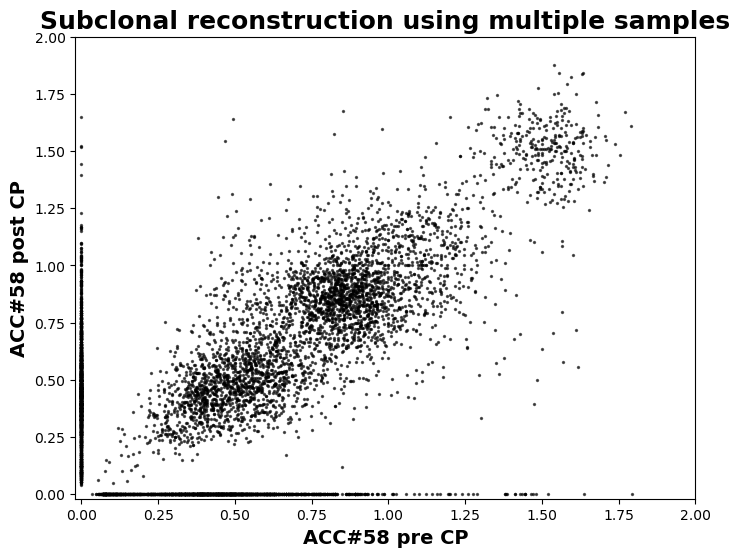

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_files(snvfile, cnafile, purityfile):
    """
    Process SNV, CNA, and purity files into a DataFrame with computed CCF.
    
    Parameters:
      - snvfile: path to the SNV file.
      - cnafile: path to the CNA file.
      - purityfile: path to the purity file.
    
    Returns:
      A pandas DataFrame containing the following columns:
        'mutation_chrom', 'mutation', 'position', 'region', 'ref_counts',
        'alt_counts', 'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity', 'ccf'
    """
    # ---------------------------
    # Load data from files.
    dfsnv = pd.read_csv(snvfile, sep='\t')
    dfcna = pd.read_csv(cnafile, sep='\t')
    with open(purityfile, 'r') as file:
        purity = float(file.read().strip())

    # ---------------------------
    # Check that required columns exist in the input files.
    required_snv_cols = {'chromosome_index', 'position', 'ref_count', 'alt_count'}
    required_cna_cols = {'chr', 'startpos', 'endpos', 'nMajor', 'nMinor'}
    missing_snv = required_snv_cols - set(dfsnv.columns)
    missing_cna = required_cna_cols - set(dfcna.columns)
    assert not missing_snv, f"Missing required columns in SNV file: {missing_snv}"
    assert not missing_cna, f"Missing required columns in CNA file: {missing_cna}"

    # Ensure purity is within a plausible range.
    assert 0 <= purity <= 1, f"Tumour purity must be between 0 and 1, but got {purity}"
    
    print(f"Loaded SNV data from {snvfile} with shape {dfsnv.shape}")
    print(f"Loaded CNA data from {cnafile} with shape {dfcna.shape}")
    print(f"Purity: {purity}")

    # ---------------------------
    # Initialize copy number lists.
    major_cn = []
    minor_cn = []
    
    # Iterate over SNV rows and match each row in the CNA DataFrame by chromosome and position range.
    for idx, row in dfsnv.iterrows():
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['chromosome_index'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            major_cn.append(matching_rows['nMajor'].iloc[0])
            minor_cn.append(matching_rows['nMinor'].iloc[0])
        else:
            major_cn.append(1)
            minor_cn.append(1)
    
    # Validate that the copy number lists have the same length as SNV rows.
    assert len(major_cn) == dfsnv.shape[0], "Length of major_cn does not match the number of SNV rows"
    assert len(minor_cn) == dfsnv.shape[0], "Length of minor_cn does not match the number of SNV rows"
    
    # ---------------------------
    # Construct the DataFrame.
    df = pd.DataFrame({
        'mutation_chrom': dfsnv['chromosome_index'],
        'mutation': dfsnv['position'],  # Preserve the mutation location if needed.
        'position': dfsnv['position'],
        'region': 1,  # Assuming region is 1 for all rows.
        'ref_counts': dfsnv['ref_count'],
        'alt_counts': dfsnv['alt_count'],
        'major_cn': major_cn,
        'minor_cn': minor_cn,
        'normal_cn': [2] * len(major_cn),
        'tumour_purity': [purity] * len(major_cn)
    })
    
    # Check that the constructed DataFrame contains all required columns.
    required_df_cols = {'mutation_chrom', 'position', 'ref_counts', 'alt_counts',
                        'major_cn', 'minor_cn', 'normal_cn', 'tumour_purity'}
    missing_df_cols = required_df_cols - set(df.columns)
    assert not missing_df_cols, f"Missing required columns in constructed DataFrame: {missing_df_cols}"
    print(f"Constructed df with shape {df.shape}")
    
    # Additional check: Randomly validate matching in the CNA file.
    sample_idx = np.random.choice(df.index, size=min(5, df.shape[0]), replace=False)
    for idx in sample_idx:
        row = df.loc[idx]
        matching_rows = dfcna[
            (dfcna['chr'] == str(row['mutation_chrom'])) & 
            (dfcna['startpos'] <= row['position']) &
            (dfcna['endpos'] >= row['position'])
        ]
        if not matching_rows.empty:
            expected_major = matching_rows['nMajor'].iloc[0]
            expected_minor = matching_rows['nMinor'].iloc[0]
            if row['major_cn'] != expected_major or row['minor_cn'] != expected_minor:
                print(f"Warning: Mismatch in row {idx}. Expected major: {expected_major}, minor: {expected_minor}; got major: {row['major_cn']}, minor: {row['minor_cn']}")
        else:
            if row['major_cn'] != 1 or row['minor_cn'] != 1:
                print(f"Warning: No match in CNA for row {idx} but found major_cn={row['major_cn']} and minor_cn={row['minor_cn']}. Expected defaults 1 and 1.")
    
    # ---------------------------
    # Calculate the CCF using the clipp2 function.
    c_mat = get_c_mat(df)
    assert c_mat.shape[0] == df.shape[0], "C-matrix row count must match number of SNV rows"
    
    ccf = df['alt_counts'] / (df['alt_counts'] + df['ref_counts'])
    ccf_vec = ccf.values.reshape(-1, 1)
    ccf_corrected = ccf_vec / c_mat
    df['ccf'] = ccf_corrected

    # ---------------------------
    # Drop rows with NaN or infinite CCF values.
    initial_rows = df.shape[0]
    df = df[np.isfinite(df['ccf'])]
    dropped_rows = initial_rows - df.shape[0]
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows} rows with invalid (NaN or infinite) CCF values.")
    
    print(f"Final CCF range: min {df['ccf'].min()}, max {df['ccf'].max()}")
    return df

def plot_subclonal_reconstruction(post_snv, post_cna, post_purity,
                                   pre_snv, pre_cna, pre_purity):
    """
    Create a scatter plot of CCF values from two datasets (post and pre) with a hexbin
    density overlay. The function takes six file paths:
    
      - post_snv: SNV file for the post sample.
      - post_cna: CNA file for the post sample.
      - post_purity: Purity file for the post sample.
      - pre_snv: SNV file for the pre sample.
      - pre_cna: CNA file for the pre sample.
      - pre_purity: Purity file for the pre sample.
    
    The function processes the data, calculates CCF, matches rows based on mutation_chrom and position,
    and then plots the scatter plot with density, using small black dots. The x‑axis and y‑axis
    limits are set using the tumour purity from each dataset plus 0.3. The title and axis labels are
    made bold and larger. No grid or legends appear.
    """
    # Process files for both datasets.
    df1 = process_files(post_snv, post_cna, post_purity)
    df2 = process_files(pre_snv, pre_cna, pre_purity)
    
    # -----------------------------------------------------------------------------
    # Build sets of unique keys (mutation_chrom, position) for each DataFrame.
    keys_df1 = set(zip(df1['mutation_chrom'], df1['position']))
    keys_df2 = set(zip(df2['mutation_chrom'], df2['position']))
    
    # Identify matched and unmatched keys.
    matched_keys       = keys_df1.intersection(keys_df2)
    unmatched_df1_keys = keys_df1 - keys_df2
    unmatched_df2_keys = keys_df2 - keys_df1
    
    # Create lookup dictionaries for fast access to the 'ccf' values.
    df1_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df1.iterrows()}
    df2_dict = {(row['mutation_chrom'], row['position']): row['ccf'] 
                for _, row in df2.iterrows()}
    
    # Process matched rows.
    x_matched = [df1_dict[key] for key in matched_keys]
    y_matched = [df2_dict[key] for key in matched_keys]
    
    # Process unmatched rows.
    # For rows that appear only in df1, set (df1['ccf'], 0)
    x_unmatched = [df1_dict[key] for key in unmatched_df1_keys]
    y_unmatched = [0 for _ in unmatched_df1_keys]
    # For rows that appear only in df2, set (0, df2['ccf'])
    x_unmatched += [0 for _ in unmatched_df2_keys]
    y_unmatched += [df2_dict[key] for key in unmatched_df2_keys]
    
    # -----------------------------------------------------------------------------
    # Plotting:
    plt.figure(figsize=(8, 6))
    
    # Combine all x and y values.
    all_x = np.concatenate([np.array(x_matched).flatten(), np.array(x_unmatched).flatten()])
    all_y = np.concatenate([np.array(y_matched).flatten(), np.array(y_unmatched).flatten()])
    
    # # Create a hexbin density plot with a finer grid; use a red colormap.
    # hb = plt.hexbin(all_x, all_y, gridsize=100, cmap='Reds', alpha=0.7, mincnt=1)
    # plt.colorbar(hb, label='Density')
    
    # Plot the scatter points with very small black dots with very low opacity (lighter).
    plt.scatter(x_matched, y_matched, color='k', s=2, alpha=0.6)
    plt.scatter(x_unmatched, y_unmatched, color='k', s=2, alpha=0.6)
    
    # Set x and y axis limits:
    # Lower bounds are set using tumour purity from each dataset plus 0.3.
    x_lower = -0.02
    y_lower = -0.02
    x_upper = 2
    y_upper = 2
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    
    # Make the axis labels and title bold and larger.
    plt.xlabel('ACC#58 pre CP', fontsize=14, fontweight='bold')
    plt.ylabel('ACC#58 post CP', fontsize=14, fontweight='bold')
    plt.title('Subclonal reconstruction using multiple samples', fontsize=18, fontweight='bold')
    
    # Remove grid.
    plt.grid(False)
    
    plt.show()

# Example call with file paths.
plot_subclonal_reconstruction('AVPC/ACC58/58-pre.snv.txt', 'AVPC/ACC58/58-pre.cna.txt', 'AVPC/ACC58/58-pre.purity.txt',
                              'AVPC/ACC58/58-post.snv.txt', 'AVPC/ACC58/58-post.cna.txt', 'AVPC/ACC58/58-post.purity.txt')